In [1]:
%load_ext autoreload
%autoreload 2

# check pytorch version
import pandas as pd
import torch
print(torch.__version__)
! pip install torch-lr-finder --quiet
# from numpy import vstack
from numpy import argmax
from sklearn.metrics import accuracy_score
from torch import Tensor
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
torch.backends.cudnn.benchmark = True
import numpy as np

1.10.0+cu111


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [28]:
%autoreload 2
!pip install livelossplot --quiet
import sys
sys.path.append('/content/gdrive/MyDrive/Sem1/CMPSCI_682/main_project/')
%cd /content/gdrive/MyDrive/Sem1/CMPSCI_682/main_project/
!ls
from src.model import ModularFC
from src.utils import *
# from src.model import FC_10
!pip install torch-lr-finder --quiet
from src.trainManager import *

device = get_default_device()
!ls inputs
train_dl, val_dl, test_dl = prepare_data('cnae-9-rishabh', 512, 512, 1024)
criterion = CrossEntropyLoss()
numOfRuns = 1

# For Plot
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

/content/gdrive/.shortcut-targets-by-id/1ZWB8WTFEdIAWtN7irt_sHbh-KeFO0l0y/main_project
 cnaeRishabh.ipynb   HelenaRis.ipynb	  outputs
 cnaeYug.ipynb	     inputs		 'Project Proposal.gdoc'
 Figures	     MiniBooneRis.ipynb   src
cnae.csv  HelenaData.csv  HelenaData.gsheet  MiniBooNE.csv
<class 'src.cnaeDataset.cnae9Dataset'> <src.cnaeDataset.cnae9Dataset object at 0x7f3cd1666d90>


In [ ]:
# def get_all_preds(model, loader):
#     all_preds = torch.tensor([])
#     for batch in loader:
#         images, labels = batch

#         preds = model(images)
#         all_preds = torch.cat( (all_preds, preds) ,dim=0 )
#     return all_preds

In [4]:
import seaborn as sns

def confusionMatrix(model, loader):
  confusion_matrix = torch.zeros(num_classes, num_classes)
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(loader):
          inputs = inputs.to(device)
          classes = classes.to(device)
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          for t, p in zip(classes.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1

  # print(confusion_matrix)
  # cm_norm = np.linalg.norm(confusion_matrix)
  # confusion_matrix = confusion_matrix/cm_norm
  # print(confusion_matrix)
  classes = [str(i) for i in range(9)]
  fig, ax = plt.subplots(figsize=(10,10))  
  ax= plt.subplot()
  confusion_matrix = confusion_matrix.numpy()
  confusion_matrix = confusion_matrix.astype(int)
  sns.heatmap(confusion_matrix, annot=True, ax = ax,fmt="d")
  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels') 
  ax.set_title('Confusion Matrix') 
  ax.xaxis.set_ticklabels(classes,rotation=90)
  ax.yaxis.set_ticklabels(classes,rotation=0)

In [5]:
def combineDict(dict1, dict2):
  for key in dict2:
    if key in dict1:
      dict1[key] += dict2[key]
    else:
      dict1[key] = dict2[key]

# Uniform distribution

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.23E-02


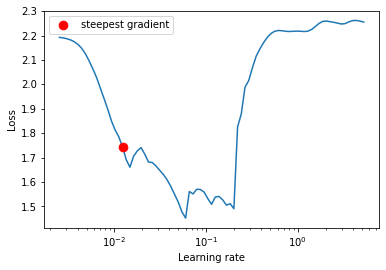

In [6]:
from torch_lr_finder import LRFinder

# path = '/content/gdrive/MyDrive/Sem1/CMPSCI_682/main_project/HelenaData.csv'

dimList = [20 for i in range(10)]
dimList = [30 for i in range(10)]
inDims = 856
num_classes = 9

# model = FC_10(27, 100, dimList)
model = ModularFC(inDims, dimList, num_classes)
lr = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

lr_finder = LRFinder(model, optimizer, criterion, device='cpu')
lr_finder.range_test(train_dl, val_dl, end_lr=10, num_iter=100, step_mode='exp')
lr_finder.plot()
lr_finder.reset()

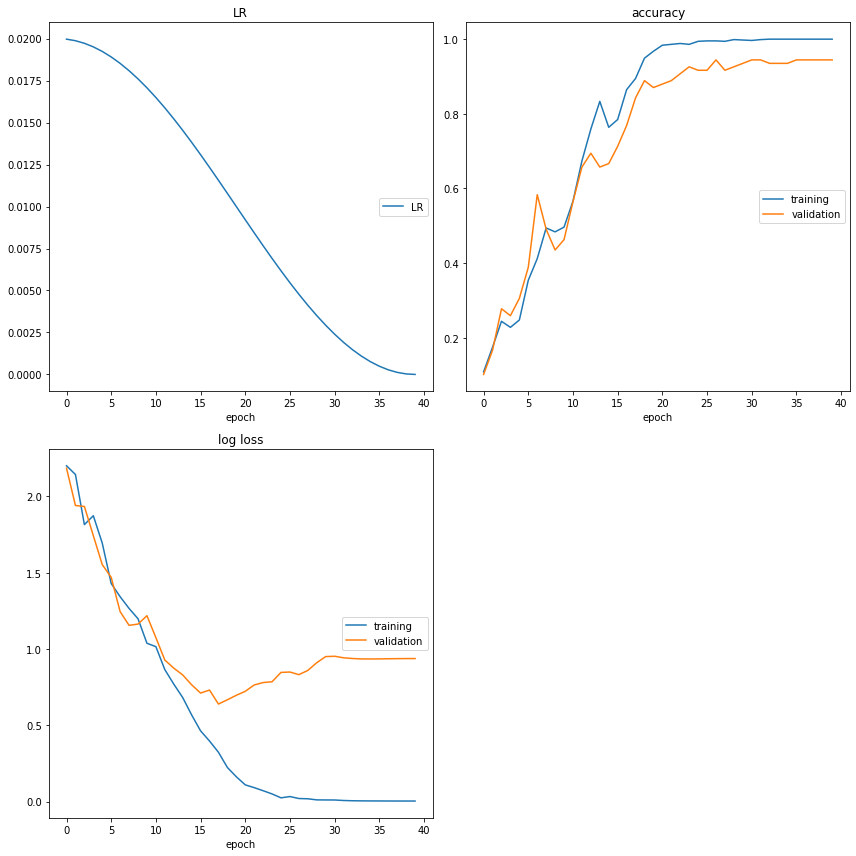

LR
	LR               	 (min:    0.000, max:    0.020, cur:    0.000)
accuracy
	training         	 (min:    0.109, max:    1.000, cur:    1.000)
	validation       	 (min:    0.102, max:    0.944, cur:    0.944)
log loss
	training         	 (min:    0.004, max:    2.201, cur:    0.004)
	validation       	 (min:    0.639, max:    2.186, cur:    0.938)


In [7]:
# prepare the data
# # path = '/content/gdrive/MyDrive/Sem1/CMPSCI_682/main_project/HelenaData.csv'
# train_dl, val_dl, test_dl = prepare_data('helena', 512, 512, 1024)

from livelossplot import PlotLosses
import matplotlib.pyplot as plt
%autoreload 2

lr_list = [2E-02]
num_epochs=40
metrics={}
for lr in lr_list:
  for i in range(numOfRuns):
    print("----------------lr: {}---------------".format(lr))
    model = ModularFC(inDims, dimList, num_classes)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    metricsCurr = train(model, optimizer, scheduler, criterion, train_dl, val_dl, epochs=num_epochs, device=device)
    combineDict(metrics, metricsCurr)

<class 'src.cnaeDataset.cnae9Dataset'> <src.cnaeDataset.cnae9Dataset object at 0x7f3cd02bbe50>


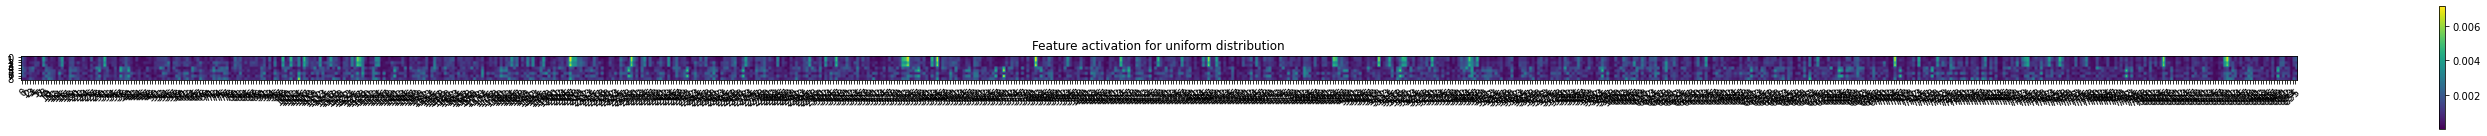

In [24]:
from src.plot_utils import *
from src.utils import compute_saliency_for_features
avg_saliency = compute_saliency_for_features(model, normalize=True, mode='test', data='cnae-9-rishabh', num_features=856, num_classes=9)
plot_saliency_by_features(avg_saliency, 9, 856, 'Feature activation for uniform distribution', 40, 2)

<class 'src.cnaeDataset.cnae9Dataset'> <src.cnaeDataset.cnae9Dataset object at 0x7f3cd0c07390>


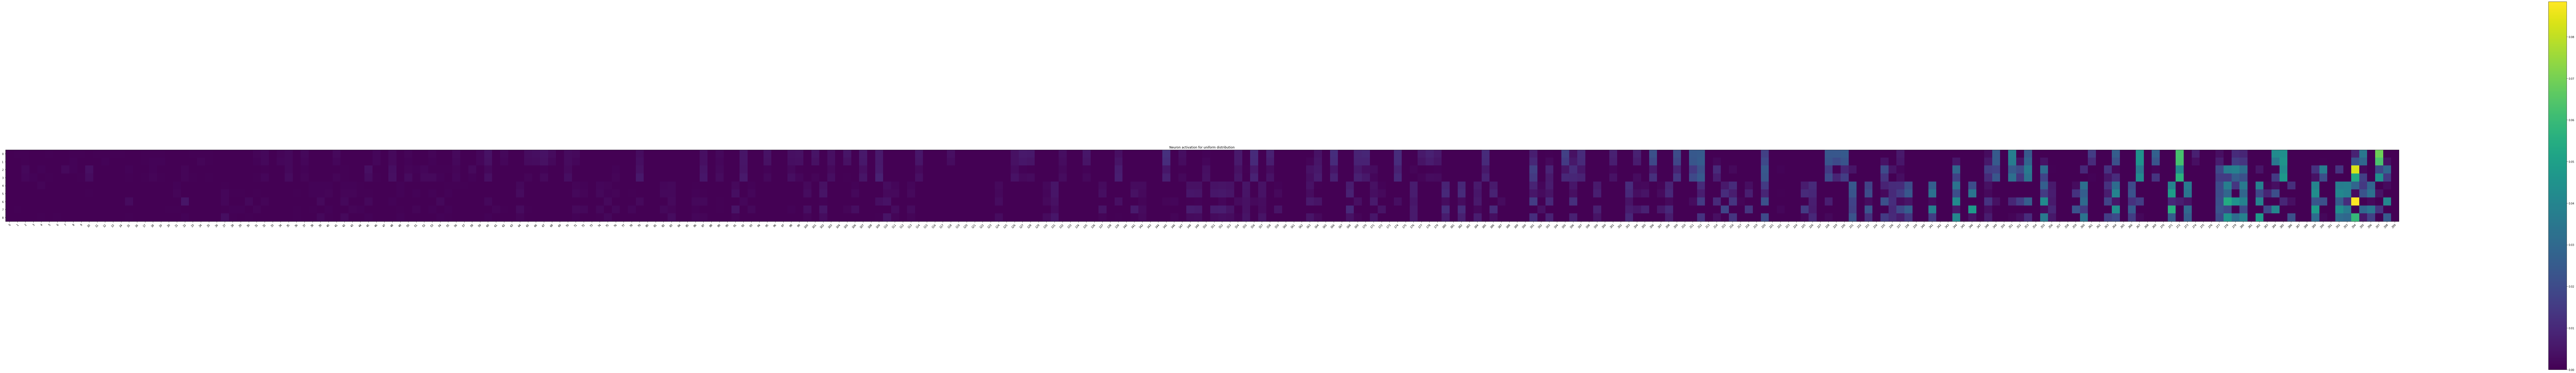

In [27]:
avg_activation = compute_model_activations(model, mode='test',num_classes=9)
plot_saliency_by_features(avg_activation, 9, 300, 'Neuron activation for uniform distribution', 160, 20)

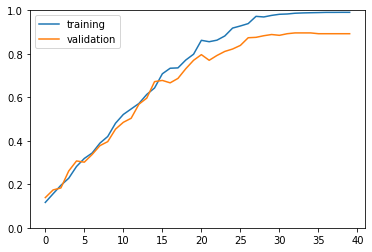

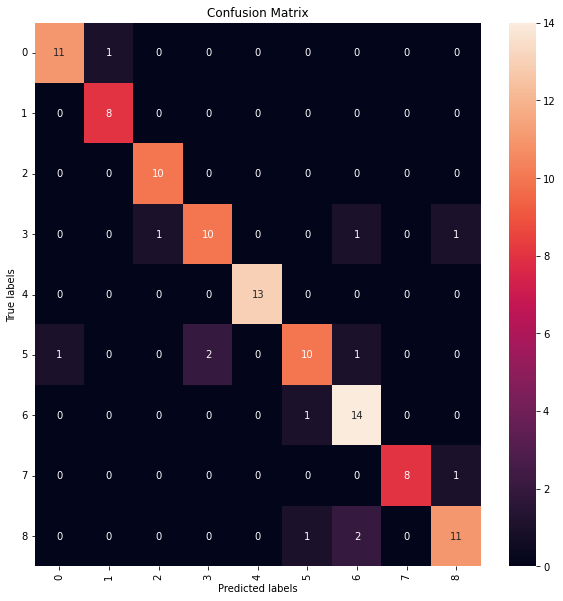

In [ ]:
plt.plot(metrics['accuracy']/numOfRuns, label='training')
plt.plot(metrics['valAccuracy']/numOfRuns, label='validation')
plt.ylim([0, 1])
plt.legend()
confusionMatrix(model, test_dl)

# Normal distribution

[11 16 33 41 49 49 41 33 16 11] 300


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.96E-02


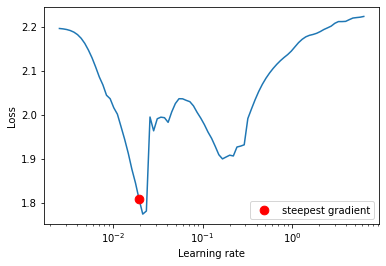

In [29]:
from torch_lr_finder import LRFinder

# path = '/content/gdrive/MyDrive/Sem1/CMPSCI_682/main_project/HelenaData.csv'

dimList = np.array([ 6, 9, 23, 28, 34, 34, 28, 23, 9,  6])
dimList = np.array([ 11, 16, 33, 41, 49, 49, 41, 33, 16, 11])
# dimList = np.array([23, 28, 34, 28, 23, 20, 17, 13, 9, 5] )
print(dimList, dimList.sum())
inDims = 856
num_classes = 9

# model = FC_10(27, 100, dimList)
model = ModularFC(inDims, dimList, num_classes)
lr = 1e-3


optimizer = torch.optim.Adam(model.parameters(), lr=lr)

lr_finder = LRFinder(model, optimizer, criterion, device='cpu')
lr_finder.range_test(train_dl, val_dl, end_lr=10, num_iter=100, step_mode='exp')
lr_finder.plot()
lr_finder.reset()

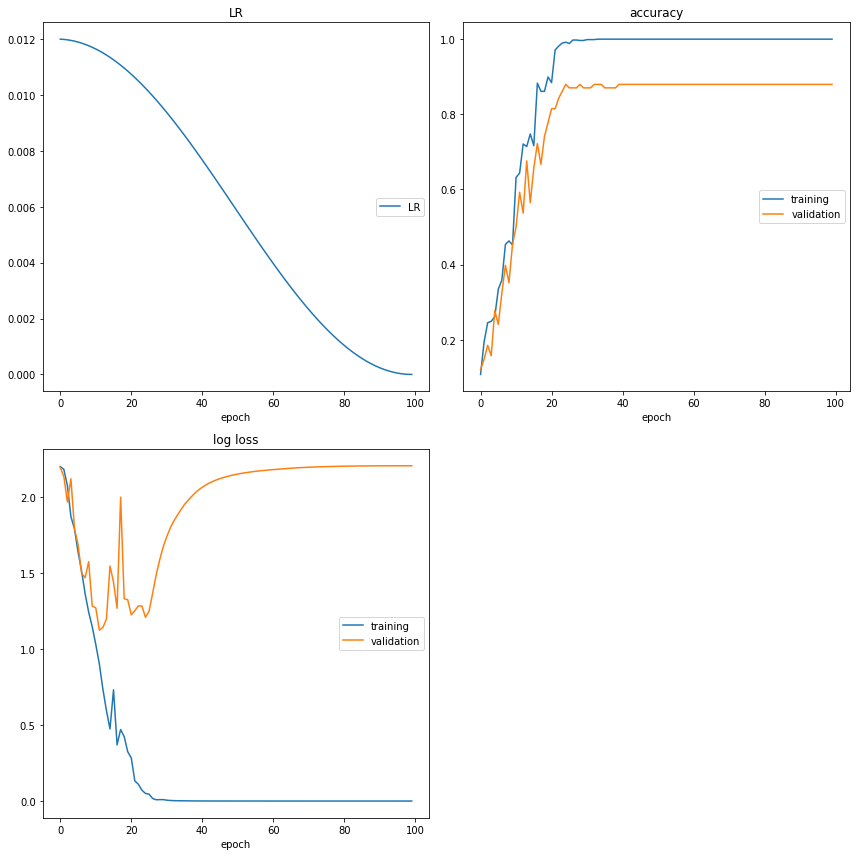

LR
	LR               	 (min:    0.000, max:    0.012, cur:    0.000)
accuracy
	training         	 (min:    0.108, max:    1.000, cur:    1.000)
	validation       	 (min:    0.120, max:    0.880, cur:    0.880)
log loss
	training         	 (min:    0.000, max:    2.201, cur:    0.000)
	validation       	 (min:    1.125, max:    2.206, cur:    2.206)


In [30]:
# prepare the data
# # path = '/content/gdrive/MyDrive/Sem1/CMPSCI_682/main_project/HelenaData.csv'
# train_dl, val_dl, test_dl = prepare_data('helena', 512, 512, 1024)

from livelossplot import PlotLosses
import matplotlib.pyplot as plt

# define the network
# train the model
lr_list = [1.2E-02]
num_epochs=100
metrics={}
for lr in lr_list:
  for i in range(numOfRuns):
    # for runs in range(5):
    print("----------------lr: {}---------------".format(lr))
    model = ModularFC(inDims, dimList, num_classes)
    model.to(device)
    # criterion = CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    metricsCurr = train(model, optimizer, scheduler, criterion, train_dl, val_dl, epochs=num_epochs, device=device)
    combineDict(metrics, metricsCurr)
    # train(train_dl, val_dl, model, 10, lr)
    # evaluate the model
    # acc = evaluate_model(test_dl, model)
    # print('Accuracy: %.3f' % acc)
    # make a single prediction
    # row = [5.1,3.5,1.4,0.2]
    # yhat = predict(row, model)
    # print('Predicted: %s (class=%d)' % (yhat, argmax(yhat)))

<class 'src.cnaeDataset.cnae9Dataset'> <src.cnaeDataset.cnae9Dataset object at 0x7f3cd03094d0>


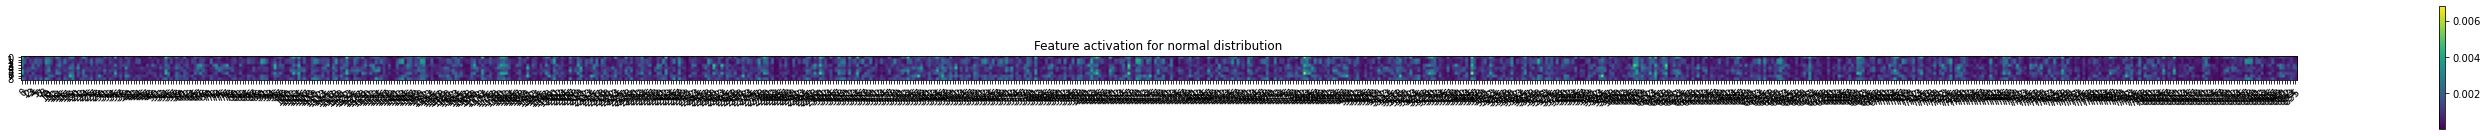

In [31]:
from src.plot_utils import *
from src.utils import compute_saliency_for_features
avg_saliency = compute_saliency_for_features(model, normalize=True, mode='test', data='cnae-9-rishabh', num_features=856, num_classes=9)
plot_saliency_by_features(avg_saliency, 9, 856, 'Feature activation for normal distribution', 40, 2)

<class 'src.cnaeDataset.cnae9Dataset'> <src.cnaeDataset.cnae9Dataset object at 0x7f3cd0201f90>


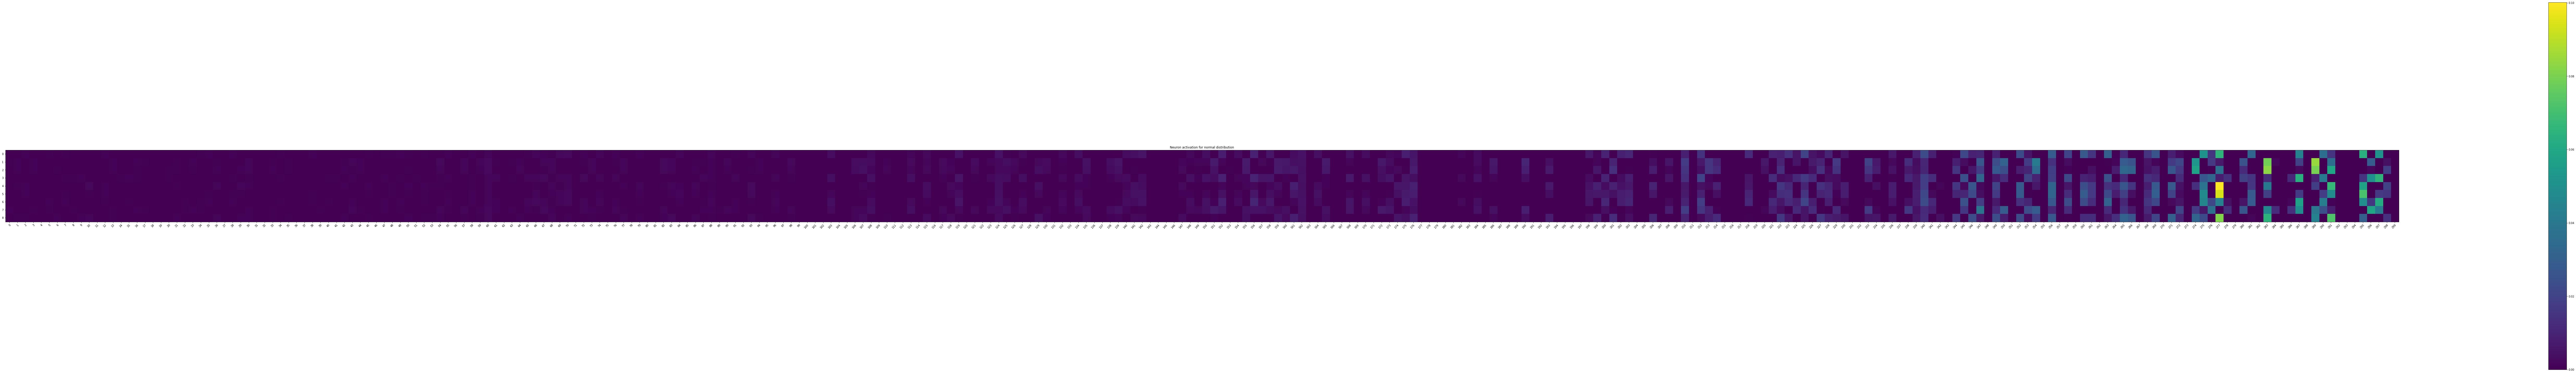

In [32]:
avg_activation = compute_model_activations(model, mode='test',num_classes=9)
plot_saliency_by_features(avg_activation, 9, 300, 'Neuron activation for normal distribution', 160, 20)

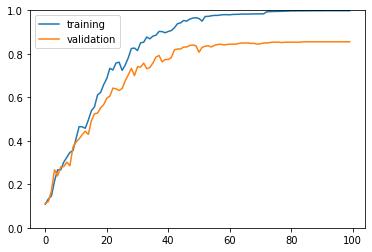

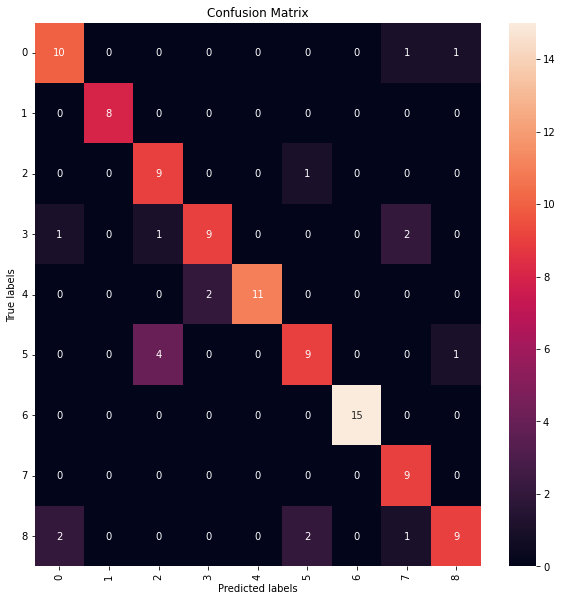

In [ ]:
plt.plot(metrics['accuracy']/numOfRuns, label='training')
plt.plot(metrics['valAccuracy']/numOfRuns, label='validation')
plt.ylim([0, 1])
plt.legend()
confusionMatrix(model, test_dl)

## Left Skew

[37 44 54 44 37 25 21 18 11  9] 300


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.76E-02


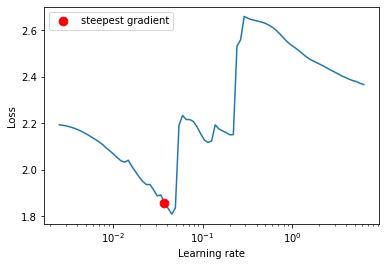

In [33]:
# dimList = np.array([ 6, 10, 15, 19, 23, 23, 19, 15, 10, 6])
# dimList = np.array([ 0.3520, 0.3866, 0.3989, 0.3866, 0.3520, 0.3, 0.2419, 0.1826, 0.1295, 0.0539])
# dimList /= dimList.sum()
# print(dimList, dimList.sum())
dimList = np.array([23, 28, 34, 28, 23, 20, 17, 13, 9, 5] )
dimList = np.array([37, 44, 54, 44, 37, 25, 21, 18, 11, 9] )
print(dimList, dimList.sum())
inDims = 856
num_classes = 9

model = ModularFC(inDims, dimList, num_classes)
lr = 1e-3


optimizer = torch.optim.Adam(model.parameters(), lr=lr)

lr_finder = LRFinder(model, optimizer, criterion, device='cpu')
lr_finder.range_test(train_dl, val_dl, end_lr=10, num_iter=100, step_mode='exp')
lr_finder.plot()
lr_finder.reset()

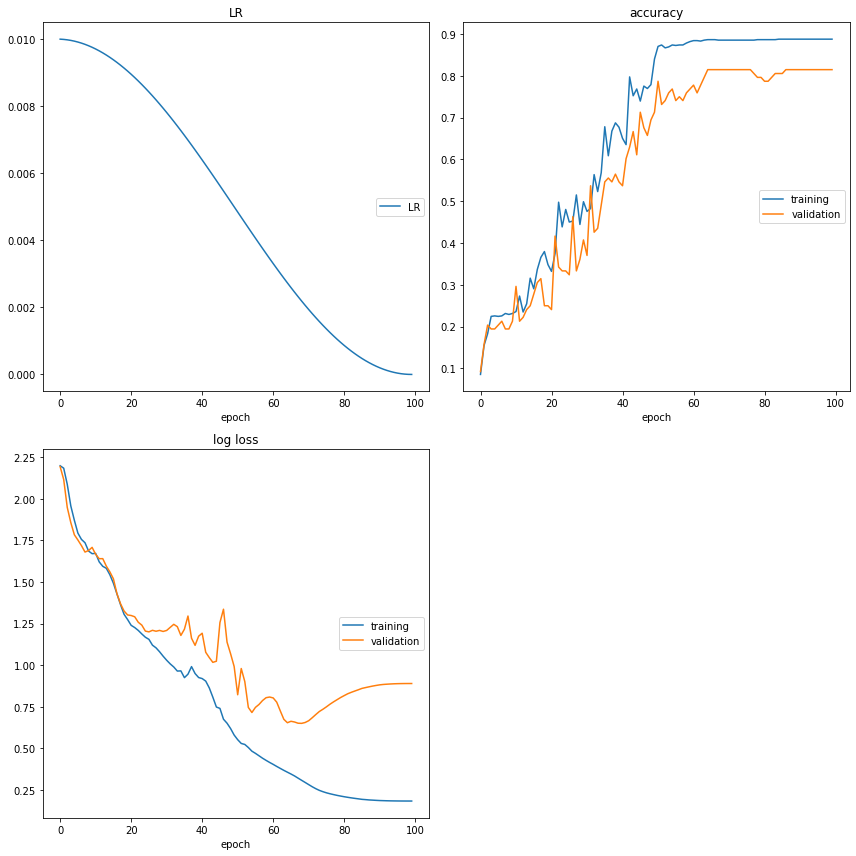

LR
	LR               	 (min:    0.000, max:    0.010, cur:    0.000)
accuracy
	training         	 (min:    0.086, max:    0.888, cur:    0.888)
	validation       	 (min:    0.093, max:    0.815, cur:    0.815)
log loss
	training         	 (min:    0.184, max:    2.199, cur:    0.184)
	validation       	 (min:    0.651, max:    2.193, cur:    0.890)


In [34]:
from livelossplot import PlotLosses
import matplotlib.pyplot as plt

# define the network
# train the model
lr_list = [1e-2]
num_epochs=100
metrics={}
for lr in lr_list:
  for i in range(numOfRuns):
    # for runs in range(5):
    print("----------------lr: {}---------------".format(lr))
    model = ModularFC(inDims, dimList, num_classes)
    model.to(device)
    # criterion = CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) #1e-5
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    metricsCurr = train(model, optimizer, scheduler, criterion, train_dl, val_dl, epochs=num_epochs, device=device)
    combineDict(metrics, metricsCurr)
    # train(train_dl, val_dl, model, 10, lr)
    # evaluate the model
    # acc = evaluate_model(test_dl, model)
    # print('Accuracy: %.3f' % acc)
    # make a single prediction
    # row = [5.1,3.5,1.4,0.2]
    # yhat = predict(row, model)
    # print('Predicted: %s (class=%d)' % (yhat, argmax(yhat)))

<class 'src.cnaeDataset.cnae9Dataset'> <src.cnaeDataset.cnae9Dataset object at 0x7f3cd0b71750>


/content/gdrive/.shortcut-targets-by-id/1ZWB8WTFEdIAWtN7irt_sHbh-KeFO0l0y/main_project/src/utils.py:142: RuntimeWarning: invalid value encountered in true_divide
  avg_saliency = avg_saliency / row_sums[:, np.newaxis]


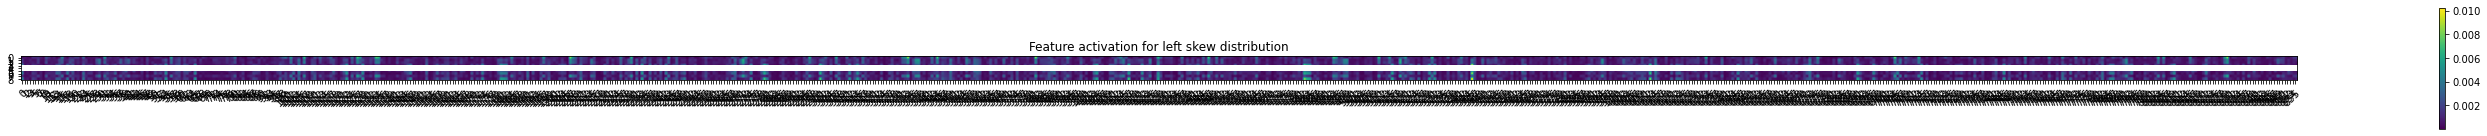

In [35]:
from src.plot_utils import *
from src.utils import compute_saliency_for_features
avg_saliency = compute_saliency_for_features(model, normalize=True, mode='test', data='cnae-9-rishabh', num_features=856, num_classes=9)
plot_saliency_by_features(avg_saliency, 9, 856, 'Feature activation for left skew distribution', 40, 2)

<class 'src.cnaeDataset.cnae9Dataset'> <src.cnaeDataset.cnae9Dataset object at 0x7f3cb6f31290>


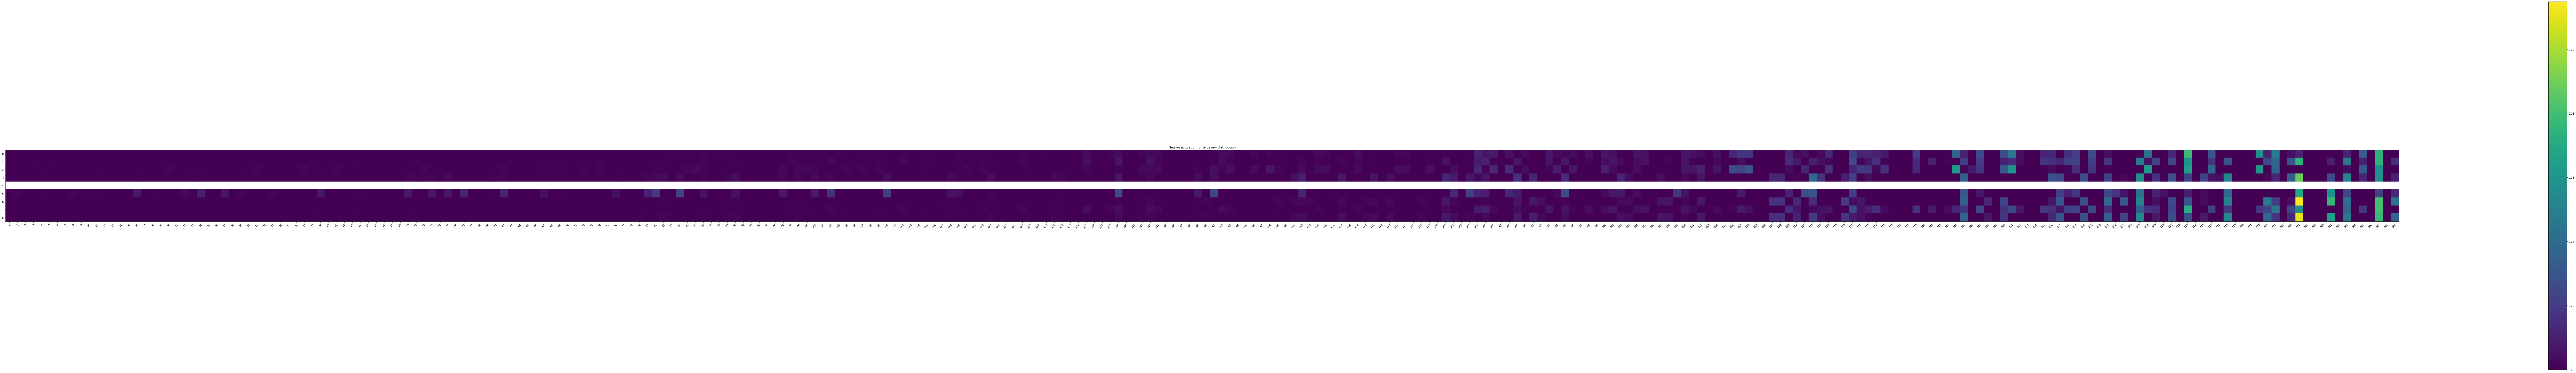

In [36]:
avg_activation = compute_model_activations(model, mode='test',num_classes=9)
plot_saliency_by_features(avg_activation, 9, 300, 'Neuron activation for left skew distribution', 160, 20)

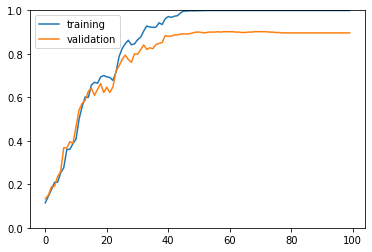

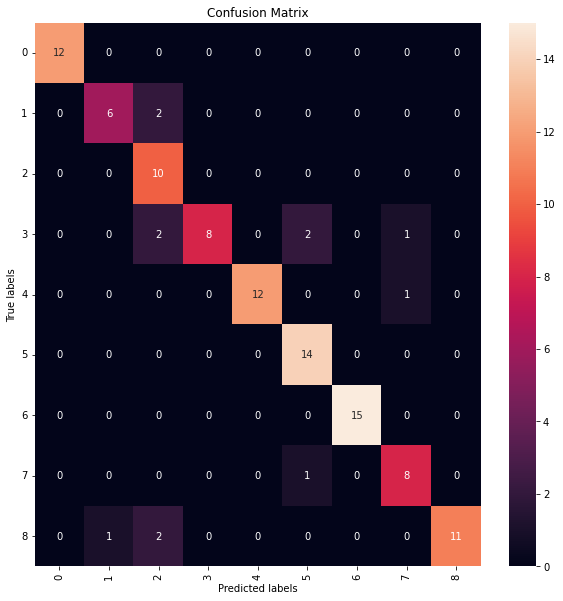

In [ ]:
plt.plot(metrics['accuracy']/numOfRuns, label='training')
plt.plot(metrics['valAccuracy']/numOfRuns, label='validation')
plt.ylim([0, 1])
plt.legend()
confusionMatrix(model, test_dl)

## Right Skew

[ 9 11 18 21 25 37 44 54 44 37] 300


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.13E-02


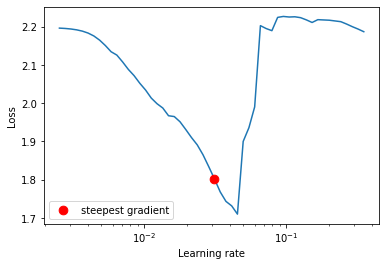

In [37]:
dimList = np.flip(np.array([23, 28, 34, 28, 23, 20, 17, 13, 9, 5] ))
dimList = np.flip(np.array([37, 44, 54, 44, 37, 25, 21, 18, 11, 9] ))
print(dimList, dimList.sum())
inDims = 856
num_classes = 9

model = ModularFC(inDims, dimList, num_classes)
lr = 1e-3


optimizer = torch.optim.Adam(model.parameters(), lr=lr)

lr_finder = LRFinder(model, optimizer, criterion, device='cpu')
lr_finder.range_test(train_dl, val_dl, end_lr=10, num_iter=100, step_mode='exp')
lr_finder.plot()
lr_finder.reset()

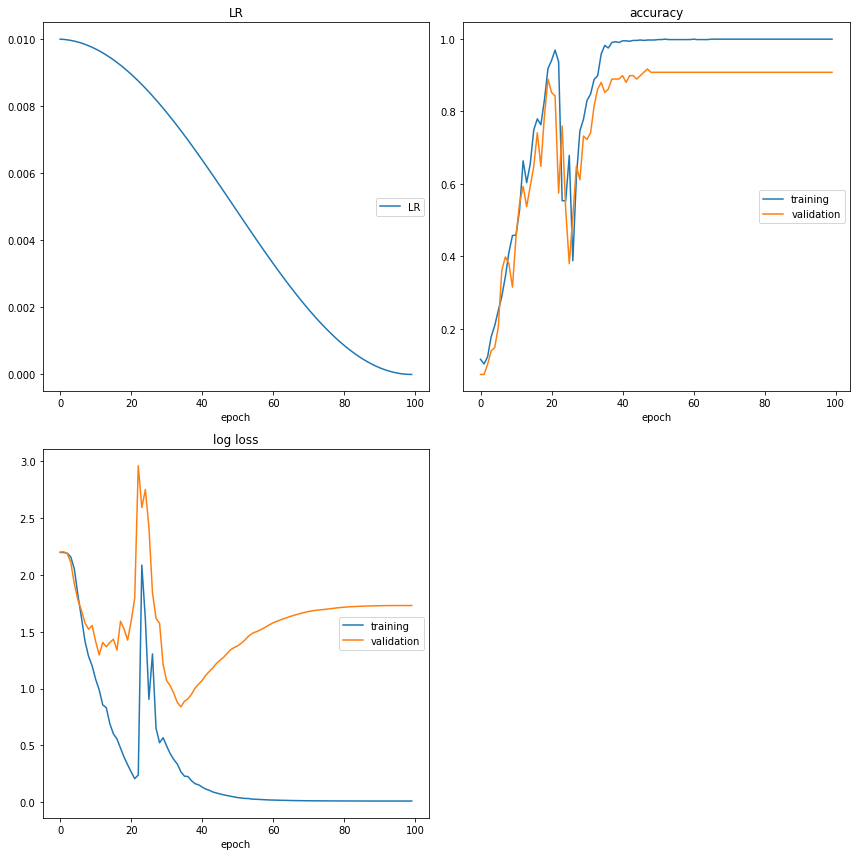

LR
	LR               	 (min:    0.000, max:    0.010, cur:    0.000)
accuracy
	training         	 (min:    0.103, max:    0.999, cur:    0.999)
	validation       	 (min:    0.074, max:    0.917, cur:    0.907)
log loss
	training         	 (min:    0.011, max:    2.198, cur:    0.011)
	validation       	 (min:    0.839, max:    2.960, cur:    1.731)


In [38]:
from livelossplot import PlotLosses
import matplotlib.pyplot as plt

# define the network
# train the model
lr_list = [1e-2]
num_epochs=100
metrics={}
for lr in lr_list:
  for i in range(numOfRuns):
    # for runs in range(5):
    print("----------------lr: {}---------------".format(lr))
    model = ModularFC(inDims, dimList, num_classes)
    model.to(device)
    # criterion = CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) #1e-6
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    metricsCurr = train(model, optimizer, scheduler, criterion, train_dl, val_dl, epochs=num_epochs, device=device)
    combineDict(metrics, metricsCurr)
    # train(train_dl, val_dl, model, 10, lr)
    # evaluate the model
    # acc = evaluate_model(test_dl, model)
    # print('Accuracy: %.3f' % acc)
    # make a single prediction
    # row = [5.1,3.5,1.4,0.2]
    # yhat = predict(row, model)
    # print('Predicted: %s (class=%d)' % (yhat, argmax(yhat)))

<class 'src.cnaeDataset.cnae9Dataset'> <src.cnaeDataset.cnae9Dataset object at 0x7f3cd0c6b5d0>


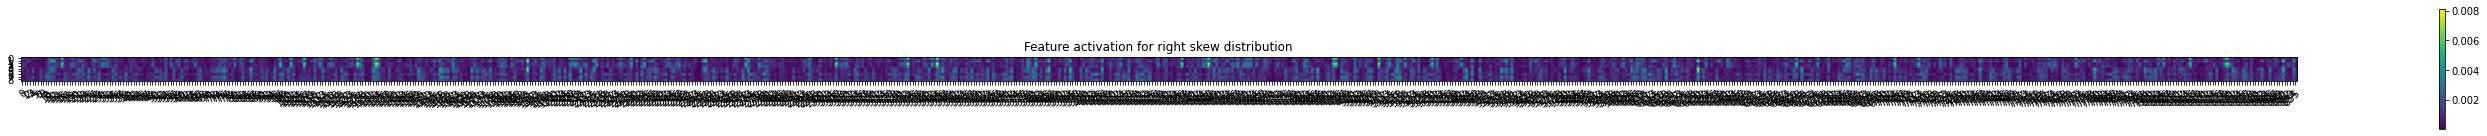

In [39]:
from src.plot_utils import *
from src.utils import compute_saliency_for_features
avg_saliency = compute_saliency_for_features(model, normalize=True, mode='test', data='cnae-9-rishabh', num_features=856, num_classes=9)
plot_saliency_by_features(avg_saliency, 9, 856, 'Feature activation for right skew distribution', 40, 2)

<class 'src.cnaeDataset.cnae9Dataset'> <src.cnaeDataset.cnae9Dataset object at 0x7f3cd2e14b10>


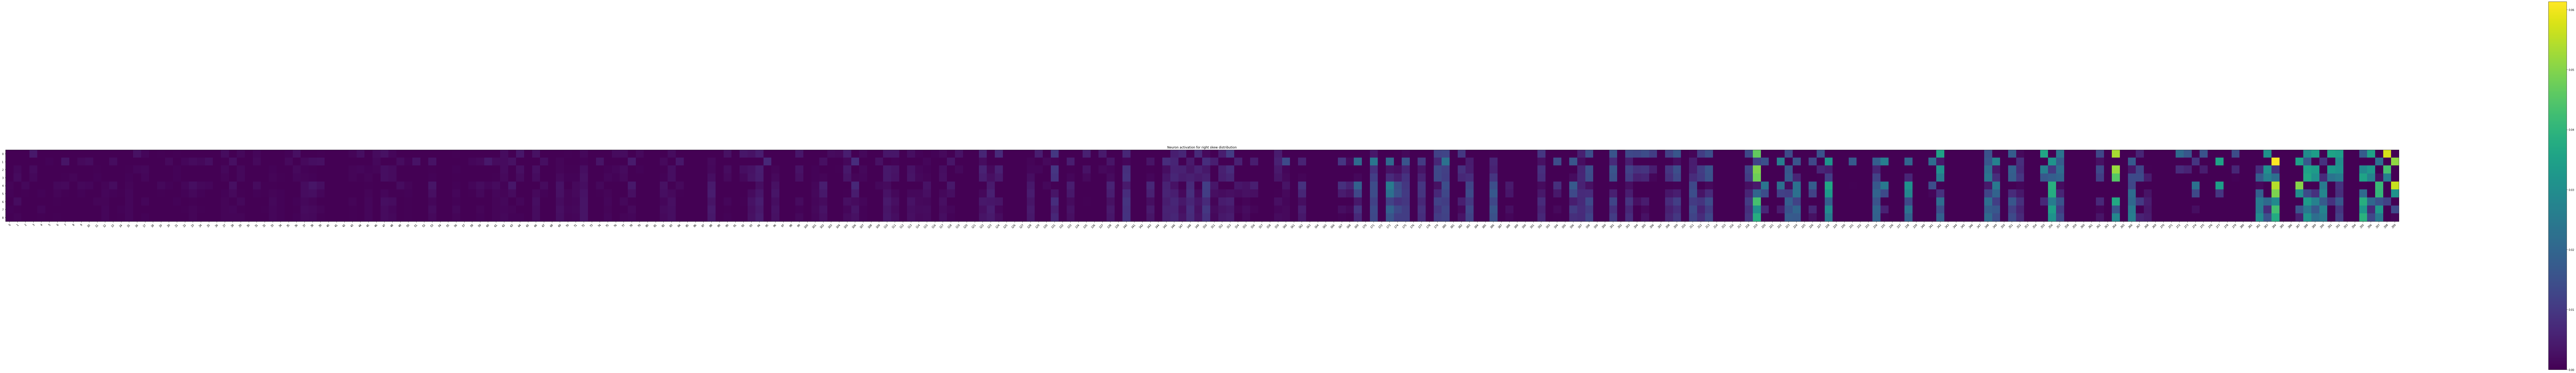

In [40]:
avg_activation = compute_model_activations(model, mode='test',num_classes=9)
plot_saliency_by_features(avg_activation, 9, 300, 'Neuron activation for right skew distribution', 160, 20)

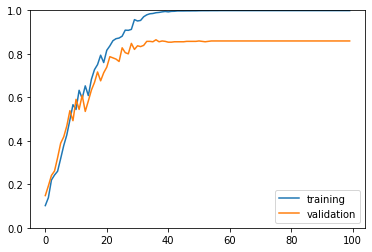

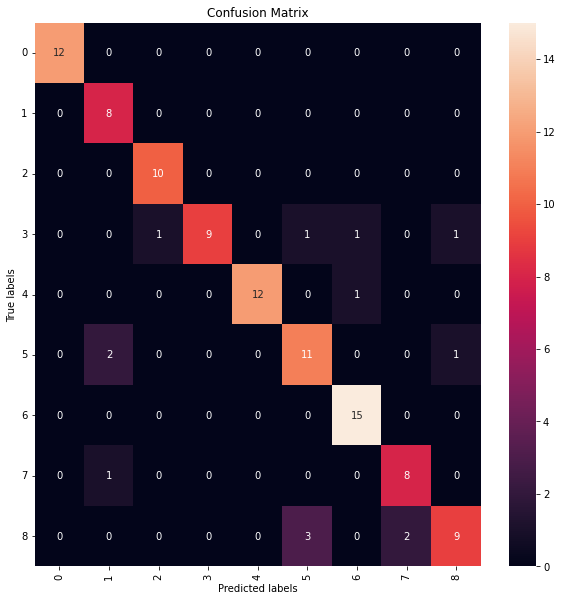

In [ ]:
plt.plot(metrics['accuracy']/numOfRuns, label='training')
plt.plot(metrics['valAccuracy']/numOfRuns, label='validation')
plt.ylim([0, 1])
plt.legend()
confusionMatrix(model, test_dl)

# Bimodal Distribution

[ 9 23 29 24 15 15 24 29 23  9] 200


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.23E-02


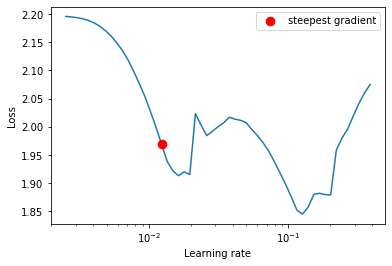

In [41]:
# dimList = np.array([ 6, 9, 23, 28, 34, 34, 28, 23, 9,  6])
dimList = np.array([ 9, 23, 29, 24, 15, 15, 24, 29, 23, 9])
print(dimList, dimList.sum())
inDims = 856
num_classes = 9

model = ModularFC(inDims, dimList, num_classes)
lr = 1e-3


optimizer = torch.optim.Adam(model.parameters(), lr=lr)

lr_finder = LRFinder(model, optimizer, criterion, device='cpu')
lr_finder.range_test(train_dl, val_dl, end_lr=10, num_iter=100, step_mode='exp')
lr_finder.plot()
lr_finder.reset()

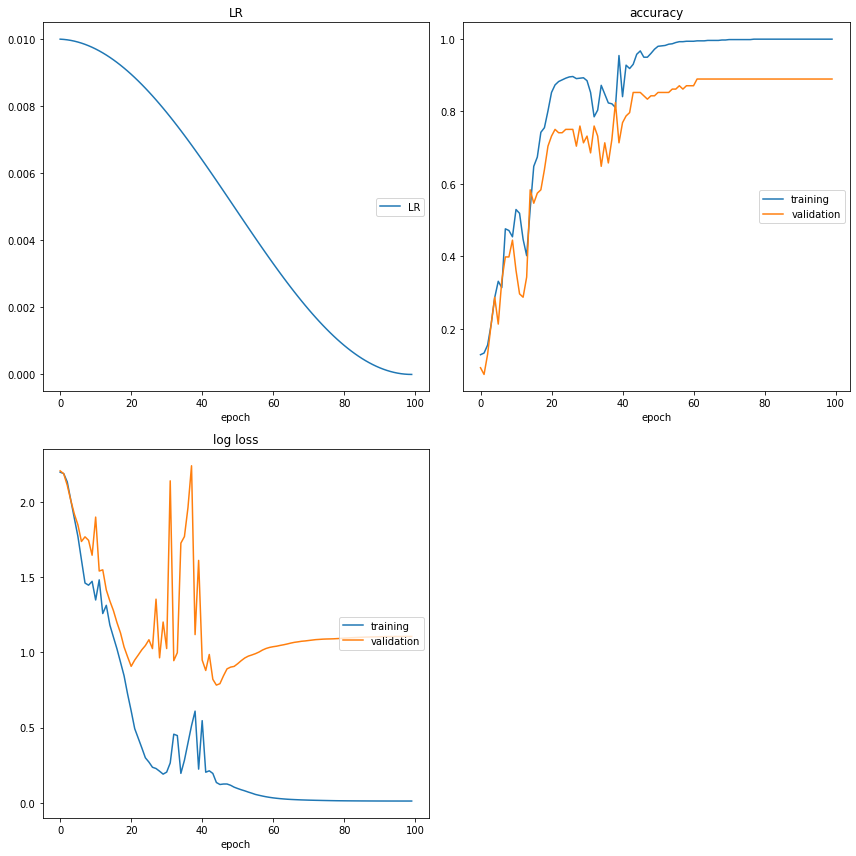

LR
	LR               	 (min:    0.000, max:    0.010, cur:    0.000)
accuracy
	training         	 (min:    0.128, max:    0.999, cur:    0.999)
	validation       	 (min:    0.074, max:    0.889, cur:    0.889)
log loss
	training         	 (min:    0.012, max:    2.198, cur:    0.012)
	validation       	 (min:    0.783, max:    2.240, cur:    1.106)


In [42]:
from livelossplot import PlotLosses
import matplotlib.pyplot as plt

# define the network
# train the model
lr_list = [1e-2]
num_epochs=100
metrics={}
for lr in lr_list:
  for i in range(numOfRuns):
    # for runs in range(5):
    print("----------------lr: {}---------------".format(lr))
    model = ModularFC(inDims, dimList, num_classes)
    model.to(device)
    # criterion = CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # 1e-5
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    metricsCurr = train(model, optimizer, scheduler, criterion, train_dl, val_dl, epochs=num_epochs, device=device)
    combineDict(metrics, metricsCurr)

<class 'src.cnaeDataset.cnae9Dataset'> <src.cnaeDataset.cnae9Dataset object at 0x7f3cb64f9510>


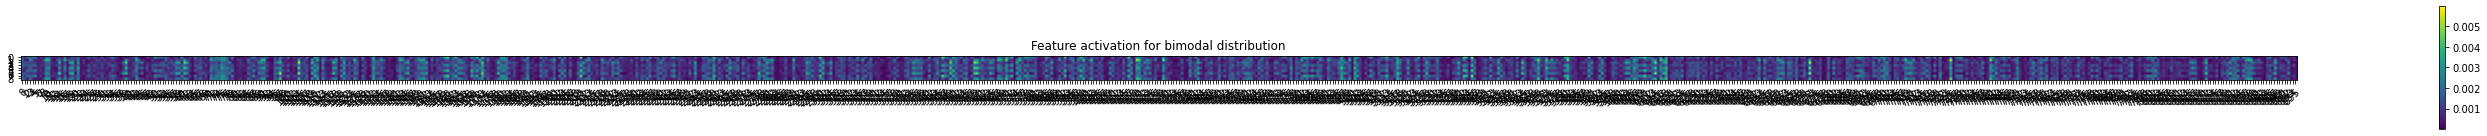

In [43]:
from src.plot_utils import *
from src.utils import compute_saliency_for_features
avg_saliency = compute_saliency_for_features(model, normalize=True, mode='test', data='cnae-9-rishabh', num_features=856, num_classes=9)
plot_saliency_by_features(avg_saliency, 9, 856, 'Feature activation for bimodal distribution', 40, 2)

<class 'src.cnaeDataset.cnae9Dataset'> <src.cnaeDataset.cnae9Dataset object at 0x7f3cb67e1ad0>


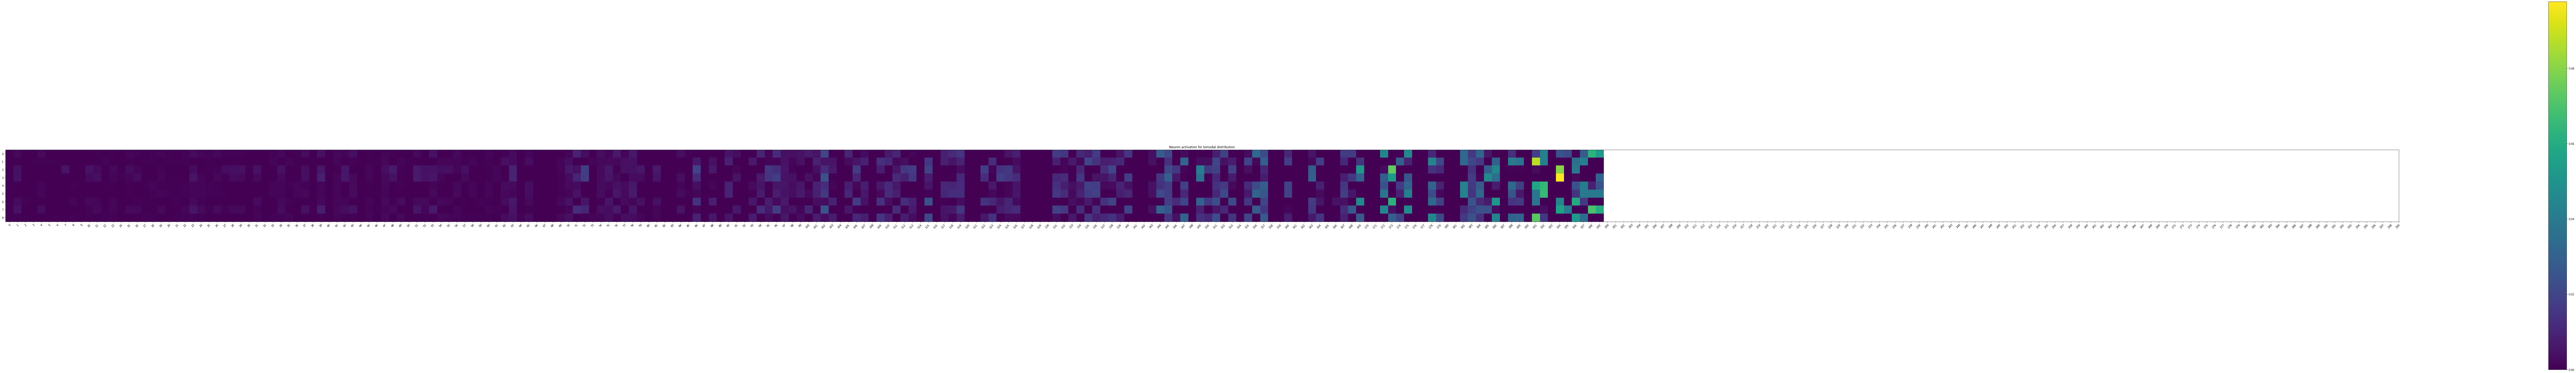

In [44]:
avg_activation = compute_model_activations(model, mode='test',num_classes=9)
plot_saliency_by_features(avg_activation, 9, 300, 'Neuron activation for bimodal distribution', 160, 20)

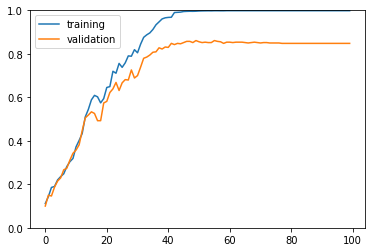

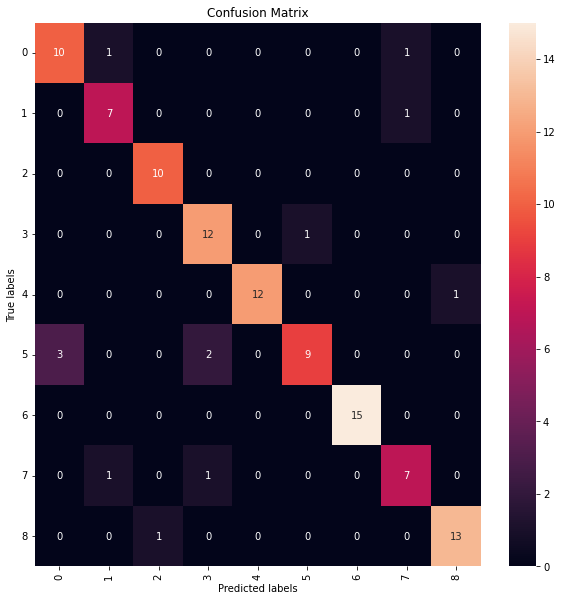

In [ ]:
plt.plot(metrics['accuracy']/numOfRuns, label='training')
plt.plot(metrics['valAccuracy']/numOfRuns, label='validation')
plt.ylim([0, 1])
plt.legend()
confusionMatrix(model, test_dl)